## Toy Problem to Explore Iterative Reconstruction of the North/South Ambiguity

In [1]:
import math
import numpy as np
from matplotlib import pylab as pl

In [2]:
## Slow code for drawing a circle
def slowCircle(D, x, y, r, v):
  for i in range(1000):
    a = i / 1000 * 2 * math.pi
    xc = x + r * math.cos(a)
    yc = y + r * math.sin(a)
    D[int(xc), int(yc)] = v

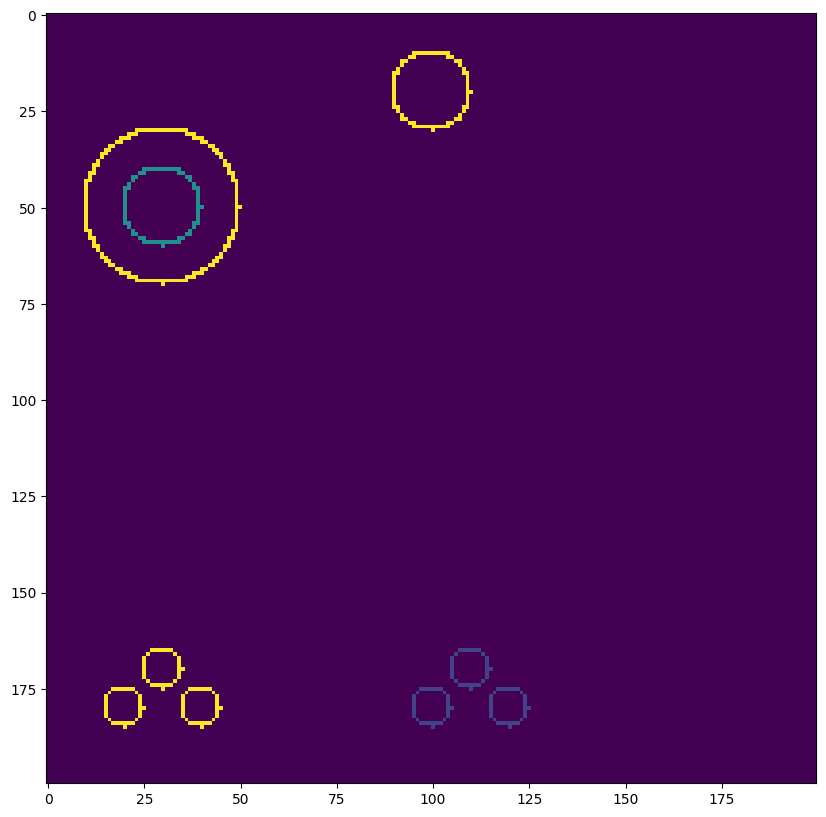

In [3]:
## Set up "ground truth" image.
D = np.zeros((200, 200))
# Northern
slowCircle(D, 30, 50, 20, 1)
slowCircle(D, 30, 50, 10, 0.5)
slowCircle(D, 100, 20, 10, 1)
# Southern
slowCircle(D, 20, 180, 5, 1)
slowCircle(D, 40, 180, 5, 1)
slowCircle(D, 30, 170, 5, 1)
slowCircle(D, 100, 180, 5, 0.2)
slowCircle(D, 120, 180, 5, 0.2)
slowCircle(D, 110, 170, 5, 0.2)

pl.figure(figsize=(10, 10))
pl.imshow(D.T, interpolation='None')

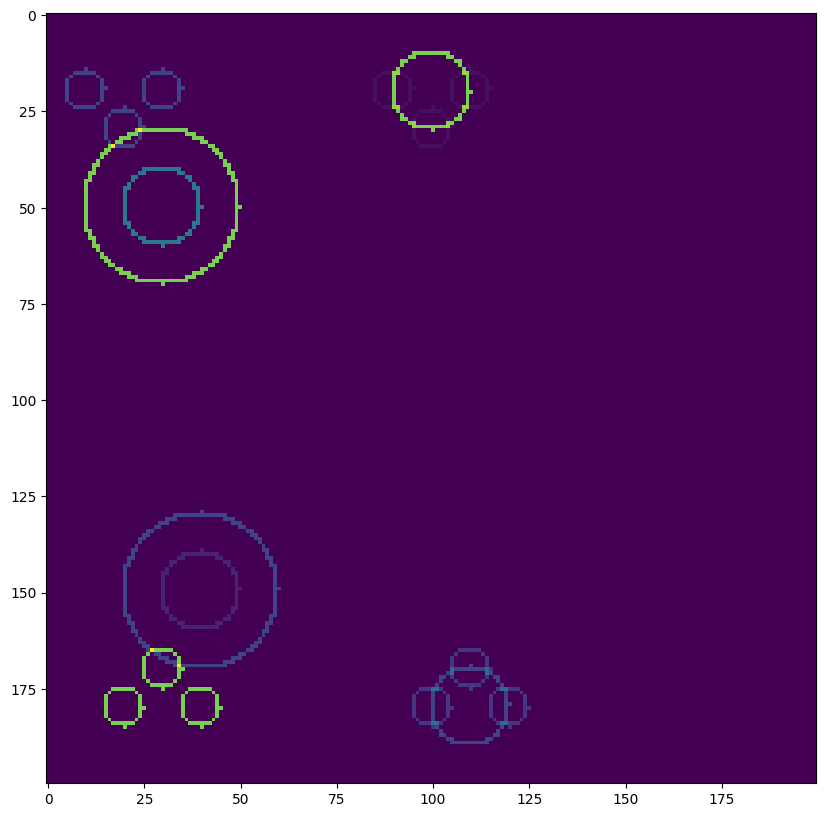

In [4]:
## Simulate the latitude ambiguity effect

def simScan(D, slew=0):
  alpha = 0.2
  Df = np.flip(D, axis=1).copy()
  Df[:, :100] = np.roll(Df[:, :100], -slew, axis=0)
  Df[:, 100:] = np.roll(Df[:, 100:], slew, axis=0)
  return (1 - alpha) * D + alpha * Df 

Ds = simScan(D, 10)

pl.figure(figsize=(10, 10))
pl.imshow(Ds.T, interpolation='None')


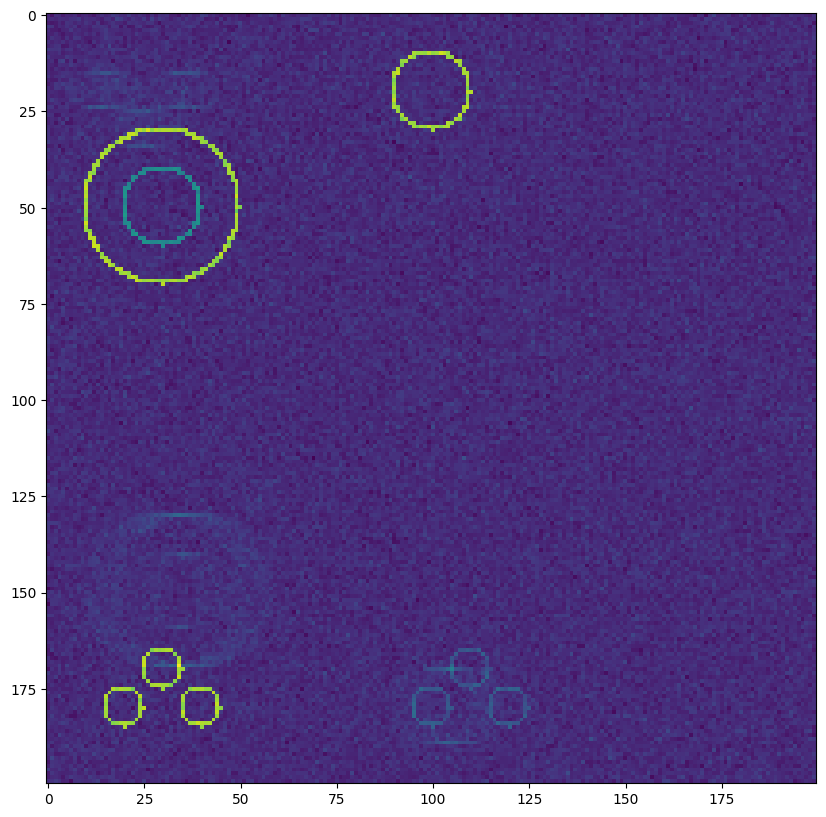

In [5]:
## Simulate multiple views

DS = []
slewSchedule = range(10)
noiseS = 0.1
for i in range(len(slewSchedule)):
  DS.append(simScan(D, slewSchedule[i]) + np.random.randn(200, 200) * noiseS)

if 1:  # Show DSave   
  DSave = np.mean(DS, axis=0)
  pl.figure(figsize=(10, 10))
  pl.imshow(DSave.T, interpolation='None')

final mse 0.01885258395097487091


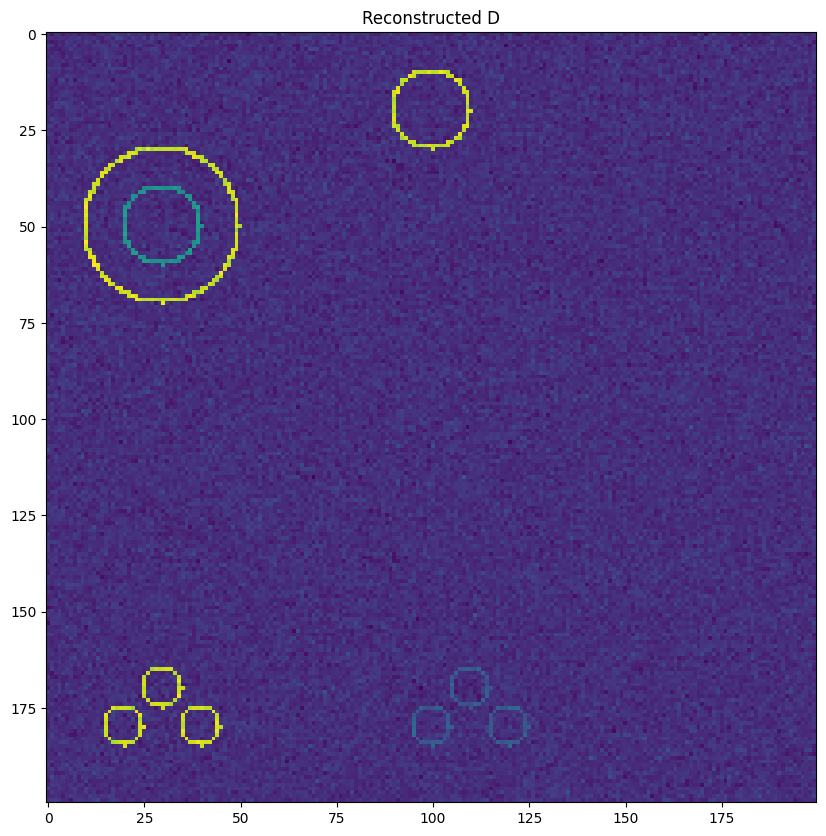

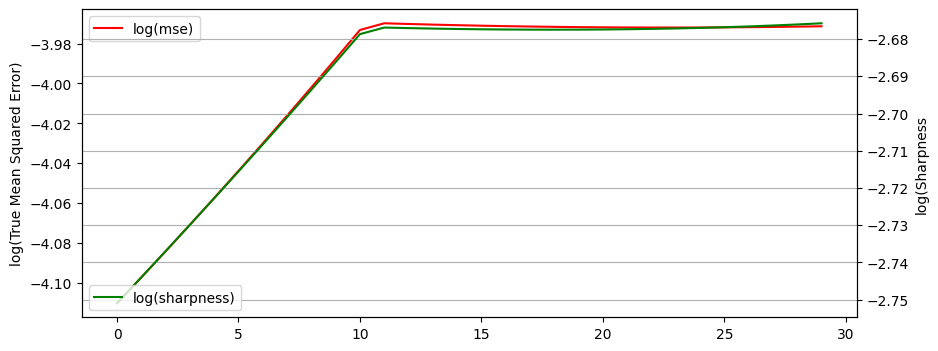

In [6]:
## Try to reconstruct ground truth from DS and slewSchedule
# Fundamental question: what is the floor for recoverable signal?

def normalizedMSE(D0, D1):
  # Normalize D0 and D1
  D0 -= D0.min()
  D0 /= D0.max()
  D1 -= D1.min()
  D1 /= D1.max()
  Derror = D0 - D1
  mse = np.mean(Derror.ravel() ** 2)
  return mse

def normalizedSharpness(D0):
  # Normalize D0
  D0 -= D0.min()
  D0 /= D0.max()
  dx = np.diff(D0, axis=1)
  dy = np.diff(D0, axis=0)
  dnorm = np.sqrt(dx[1:,:]**2 + dy[:,1:]**2)
  sharpness = np.mean(dnorm)
  return sharpness

DC = DS.copy()
if 1:  # Normalize the Dc
  for i in range(len(DC)):
    Dc = DC[i]
    Dc -= Dc.min()
    Dc /= Dc.max()
    DC[i] = Dc

if 1: # Normalize D
  D -= D.min()
  D /= D.max()

SHA = []
MSE = []

# 1. Why does the MSE go *up* in the first iteration?
# 2. Is there a way to auto-tune this? (without knowing true Derror)
# - Maximize general image sharpness?
#  - Sweep beta for max sharpness?
for j in range(30):
  # DCave is our current best estimate (average of multiple views)
  DCave = np.mean(DC, axis=0)
  sharpness = normalizedSharpness(DCave.copy())  # Always use copies, to be sure
  SHA.append(sharpness)
  #print("sha", sharpness)
  mse = normalizedMSE(D.copy(), DCave.copy())  # Always use copies, to be sure
  MSE.append(mse)
  #print("mse %.20f" % mse)
  DCnew = []
  for i in range(len(slewSchedule)):
    slew = slewSchedule[i]
    # Apply anti-slew to our current best estimate
    DCaves = DCave.copy()
    DCaves[:, :100] = np.roll(DCaves[:, :100], slew, axis=0)
    DCaves[:, 100:] = np.roll(DCaves[:, 100:], -slew, axis=0)
    # Subtract beta * anti-slewed best estimate from the opposing hemisphere
    # Note: the ground truth blending function is 0.2, so I think the optimal beta should be 0.25,
    # since 1 - 1 / 1.25 = 0.2)
    #Dc = DS[i].copy()  # Note: DS[i] is the original observation
    #beta = 0.25
    # If we don't know optimal beta, using DC and a low beta value *does* lead to some convergence.
    Dc = DC[i].copy()
    beta = 0.01   
    Dc[:, :100] -= beta * np.flip(DCaves[:, 100:], axis=1)
    Dc[:, 100:] -= beta * np.flip(DCaves[:, :100], axis=1)
    DCnew.append(Dc)
  DC = DCnew

DCave = np.mean(DC, axis=0)
mse = normalizedMSE(D, DCave)
print("final mse %.20f" % mse)

if 0:
  Derror = D - DCave
  pl.figure(figsize=(10, 10))
  pl.imshow(Derror.T, interpolation='None')
  pl.title('Derror')

if 1:
  pl.figure(figsize=(10, 10))
  pl.imshow(DCave.T, interpolation='None')
  pl.title('Reconstructed D')

if 1:
  pl.figure(figsize=(10, 4))
  ax1 = pl.gca()
  ax1.plot(np.log(MSE), 'r-', label='log(mse)')
  ax1.set_ylabel('log(True Mean Squared Error)')
  ax2 = pl.gca().twinx()
  ax2.plot(np.log(SHA), 'g-', label='log(sharpness)')
  ax2.set_ylabel('log(Sharpness')
  ax1.legend(loc='upper left')
  ax2.legend(loc='lower left')
  pl.grid()